# GIK Character Prediction Model Training

This notebook trains an LSTM model to predict keyboard characters from IMU sensor data.

## Pipeline Overview:
1. **Preprocessing**: Load and filter IMU data, align with keyboard events
2. **Dataset Creation**: Create labeled samples (IMU features → character)
3. **Model Training**: Train LSTM model with classification head
4. **Evaluation**: Analyze model performance

## 1. Setup and Imports

In [1]:
# Fix OpenMP library conflict (must be before importing torch)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Import preprocessing and model modules
from pretraining import (
    preprocess_and_export,
    load_preprocessed_dataset,
    export_dataset_to_csv,
    IMUFilterConfig,
    INDEX_TO_CHAR,
    CHAR_TO_INDEX
)

from ml.models.basic_nn import (
    create_model_from_dataset,
    GIKTrainer,
    decode_predictions,
    LSTMModel,
    GIKModelWrapper
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'}")

PyTorch version: 2.10.0
Device: mps


## 2. Configuration

In [2]:
# Data paths
DATA_DIR = "data"
KEYBOARD_CSV = os.path.join(DATA_DIR, "Keyboard_2.csv")
RIGHT_CSV = os.path.join(DATA_DIR, "Right_2.csv")
LEFT_CSV = os.path.join(DATA_DIR, "None")  # Set to None if not available

# Preprocessed data output path
PROCESSED_DATA_PATH = os.path.join(DATA_DIR, "processed_dataset.pt")

# Training configuration
CONFIG = {
    'max_seq_length': 10,       # Max timesteps per sample
    'hidden_dim': 128,          # LSTM hidden dimension
    'num_layers': 2,            # LSTM layers
    'bidirectional': True,      # Bidirectional LSTM
    'dropout': 0.3,             # Dropout rate
    'batch_size': 16,           # Training batch size
    'learning_rate': 1e-3,      # Learning rate
    'epochs': 100,              # Max epochs
    'early_stopping': 15,       # Early stopping patience
}

# Check which files exist
print("Data files:")
print(f"  Keyboard: {os.path.exists(KEYBOARD_CSV)}")
print(f"  Right IMU: {os.path.exists(RIGHT_CSV)}")
print(f"  Left IMU: {os.path.exists(LEFT_CSV) if LEFT_CSV else 'N/A'}")

Data files:
  Keyboard: True
  Right IMU: True
  Left IMU: False


## 3. Data Preprocessing

Apply IMU filtering (Kalman filter, drift removal) and align with keyboard events.

In [3]:
# Configure IMU filtering
filter_config = IMUFilterConfig(
    apply_kalman=True,           # Apply Kalman filter for attitude estimation
    apply_drift_removal=True,    # Remove acceleration drift
    apply_bandpass=False,        # Optional bandpass filter
    bandpass_cutoff=(0.1, 15),   # Bandpass cutoff frequencies
    noise_coefficients={'g': 10, 'a': 35, 'm': 10},  # Sensor noise coefficients
    drift_threshold=0.2,         # Motion detection threshold
    use_magnetometer=False       # Whether to use magnetometer
)

# Check if Left CSV exists
left_csv = LEFT_CSV if LEFT_CSV and os.path.exists(LEFT_CSV) else None

print("Starting preprocessing...")
print(f"  Right hand: {RIGHT_CSV}")
print(f"  Left hand: {left_csv if left_csv else 'Not available'}")
print(f"  Keyboard: {KEYBOARD_CSV}")

Starting preprocessing...
  Right hand: data/Right_2.csv
  Left hand: Not available
  Keyboard: data/Keyboard_2.csv


In [4]:
# Preprocess and export dataset
metadata = preprocess_and_export(
    keyboard_csv=KEYBOARD_CSV,
    right_csv=RIGHT_CSV,
    left_csv=left_csv,
    output_path=PROCESSED_DATA_PATH,
    max_seq_length=CONFIG['max_seq_length'],
    normalize=True,
    apply_filtering=True,
    filter_config=filter_config
)

print("\nPreprocessing complete!")
print(f"Metadata: {metadata}")

Loading data...
Aligning IMU data with keyboard events...
Processing 77 samples...
Saved preprocessed dataset to data/processed_dataset.pt
Saved metadata to data/processed_dataset_metadata.json
  - Samples: 77
  - Input dim: 41
  - Hands: 1

Preprocessing complete!
Metadata: {'num_samples': 77, 'num_hands': 1, 'has_right': True, 'has_left': False, 'input_dim': 41, 'max_seq_length': 10, 'num_classes': 40, 'filter_applied': True}


### Export to CSV for Inspection

Export the preprocessed dataset to CSV files:
- `dataset_summary.csv`: One row per sample with label and statistics
- `dataset_features.csv`: Full feature data (timestep × features per sample)

In [5]:
# Export dataset to CSV for inspection
export_dataset_to_csv(
    pt_path=PROCESSED_DATA_PATH,
    output_dir=DATA_DIR,
    include_features=True,  # Set to False if dataset is large
    max_samples=None  # Set a number to limit samples exported
)

Saved summary to data/dataset_summary.csv
Saved features to data/dataset_features.csv

Dataset Info:
  Total samples: 77
  Exported samples: 77
  Input dim: 41
  Max seq length: 10
  Num classes: 40

Class Distribution:
  SPACE: 14
  BACKSPACE: 8
  y: 7
  c: 7
  l: 5
  n: 5
  o: 4
  m: 4
  t: 3
  u: 3
  g: 3
  v: 3
  ENTER: 3
  d: 2
  i: 1


'data/dataset_summary.csv'

## 4. Load Preprocessed Dataset

In [6]:
# Load the preprocessed dataset
dataset = load_preprocessed_dataset(PROCESSED_DATA_PATH)

print(f"Dataset loaded:")
print(f"  Samples: {len(dataset)}")
print(f"  Input dim: {dataset.input_dim}")
print(f"  Num hands: {dataset.num_hands}")
print(f"  Has right: {dataset.has_right}")
print(f"  Has left: {dataset.has_left}")

# Inspect a sample
sample, label = dataset[0]
print(f"\nSample shape: {sample.shape}")
print(f"Label shape: {label.shape}")
print(f"Label (one-hot): {label}")
print(f"Predicted char: {INDEX_TO_CHAR[label.argmax().item()]}")

Dataset loaded:
  Samples: 77
  Input dim: 41
  Num hands: 1
  Has right: True
  Has left: False

Sample shape: torch.Size([10, 41])
Label shape: torch.Size([40])
Label (one-hot): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])
Predicted char: y


## 5. Visualize Data Distribution

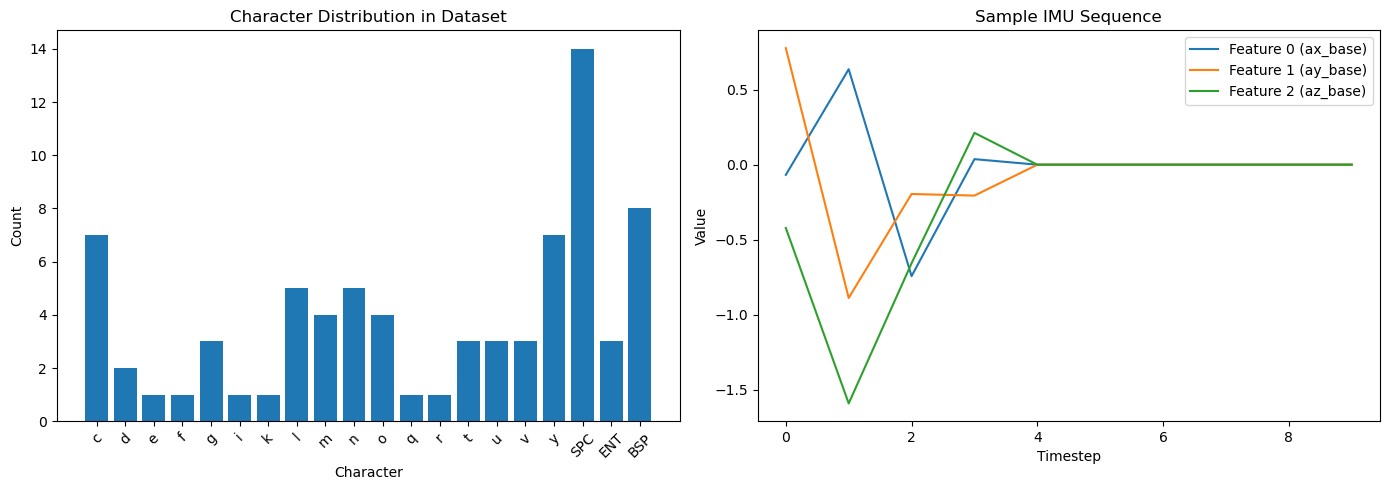

In [7]:
# Plot class distribution
labels = dataset.labels.numpy()
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(14, 5))

# Bar chart of class distribution
plt.subplot(1, 2, 1)
chars = [INDEX_TO_CHAR.get(i, '?') for i in unique]
chars = ['SPC' if c == ' ' else 'ENT' if c == '\n' else 'BSP' if c == '\b' else 'TAB' if c == '\t' else c for c in chars]
plt.bar(range(len(unique)), counts)
plt.xticks(range(len(unique)), chars, rotation=45)
plt.xlabel('Character')
plt.ylabel('Count')
plt.title('Character Distribution in Dataset')

# Sample IMU data visualization
plt.subplot(1, 2, 2)
sample_data = dataset.samples[0].numpy()
plt.plot(sample_data[:, 0], label='Feature 0 (ax_base)')
plt.plot(sample_data[:, 1], label='Feature 1 (ay_base)')
plt.plot(sample_data[:, 2], label='Feature 2 (az_base)')
plt.xlabel('Timestep')
plt.ylabel('Value')
plt.title('Sample IMU Sequence')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Create LSTM Model

In [8]:
# Create LSTM model using factory function
model = create_model_from_dataset(
    dataset=dataset,
    model_type='lstm',
    hidden_dim=CONFIG['hidden_dim'],
    num_layers=CONFIG['num_layers'],
    bidirectional=CONFIG['bidirectional'],
    dropout=CONFIG['dropout']
)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model Architecture:
GIKModelWrapper(
  (input_projection): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (inner_model): LSTMModel(
    (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (projection): Linear(in_features=256, out_features=128, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=40, bias=True)
  )
)

Total parameters: 708,840
Trainable parameters: 708,840


## 7. Train the Model

In [9]:
# Create trainer
trainer = GIKTrainer(
    model=model,
    dataset=dataset,
    batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['learning_rate'],
    val_split=0.2
)

print(f"Training configuration:")
print(f"  Device: {trainer.device}")
print(f"  Train samples: {len(trainer.train_dataset)}")
print(f"  Val samples: {len(trainer.val_dataset)}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")

Training configuration:
  Device: mps
  Train samples: 62
  Val samples: 15
  Batch size: 16
  Learning rate: 0.001


In [10]:
# Train the model
history = trainer.train(
    epochs=CONFIG['epochs'],
    early_stopping_patience=CONFIG['early_stopping'],
    save_best=True,
    save_path='best_model.pt'
)

Training on mps
Train samples: 62, Val samples: 15
------------------------------------------------------------
Epoch   1/100 | Train Loss: 3.6753 | Train Acc: 0.0161 | Val Loss: 3.6575 | Val Acc: 0.0000
  -> Saved best model (val_loss: 3.6575)
Epoch   2/100 | Train Loss: 3.6235 | Train Acc: 0.0161 | Val Loss: 3.6364 | Val Acc: 0.0000
  -> Saved best model (val_loss: 3.6364)
Epoch   3/100 | Train Loss: 3.5293 | Train Acc: 0.0323 | Val Loss: 3.6175 | Val Acc: 0.0000
  -> Saved best model (val_loss: 3.6175)
Epoch   4/100 | Train Loss: 3.5070 | Train Acc: 0.0161 | Val Loss: 3.6168 | Val Acc: 0.0667
  -> Saved best model (val_loss: 3.6168)
Epoch   5/100 | Train Loss: 3.4140 | Train Acc: 0.0484 | Val Loss: 3.6111 | Val Acc: 0.0667
  -> Saved best model (val_loss: 3.6111)
Epoch   6/100 | Train Loss: 3.3269 | Train Acc: 0.0484 | Val Loss: 3.6257 | Val Acc: 0.0000
Epoch   7/100 | Train Loss: 3.2027 | Train Acc: 0.0968 | Val Loss: 3.6432 | Val Acc: 0.0000
Epoch   8/100 | Train Loss: 3.1131 | Tr

## 8. Visualize Training Results

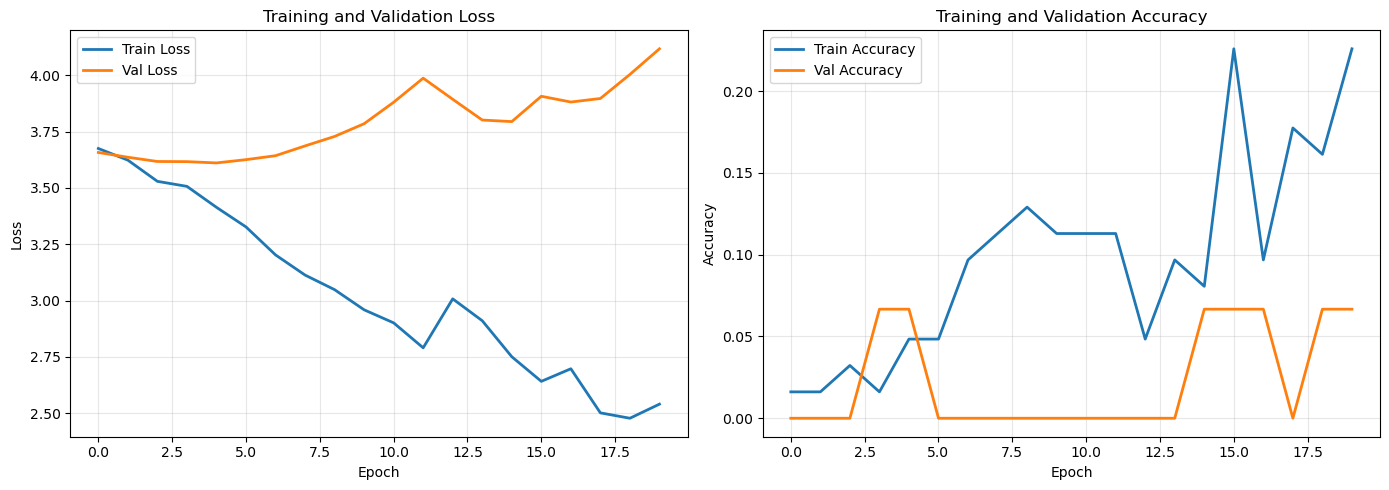


Best validation loss: 3.6111
Best validation accuracy: 0.0667


In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

print(f"\nBest validation loss: {min(history['val_loss']):.4f}")
print(f"Best validation accuracy: {max(history['val_acc']):.4f}")

## 9. Evaluate Model

In [12]:
# Load best model
trainer.load_best_model('best_model.pt')

# Evaluate on validation set
val_loss, val_acc = trainer.validate()
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")

Loaded model from best_model.pt
Final Validation Loss: 3.6111
Final Validation Accuracy: 0.0667


In [13]:
# Make predictions on a few samples
model.eval()

print("Sample Predictions:")
print("-" * 50)

with torch.no_grad():
    for i in range(min(10, len(dataset))):
        sample, label = dataset[i]
        sample = sample.unsqueeze(0).to(trainer.device)  # Add batch dim
        
        # Get prediction
        probs = model.predict_proba(sample)
        pred_idx = probs.argmax(dim=-1).item()
        confidence = probs[0, pred_idx].item()
        
        # Get actual label
        actual_idx = label.argmax().item()
        
        # Convert to characters
        pred_char = INDEX_TO_CHAR.get(pred_idx, '?')
        actual_char = INDEX_TO_CHAR.get(actual_idx, '?')
        
        # Format special chars for display
        pred_display = 'SPACE' if pred_char == ' ' else 'ENTER' if pred_char == '\n' else pred_char
        actual_display = 'SPACE' if actual_char == ' ' else 'ENTER' if actual_char == '\n' else actual_char
        
        match = "✓" if pred_idx == actual_idx else "✗"
        print(f"  {match} Actual: {actual_display:6} | Predicted: {pred_display:6} | Confidence: {confidence:.2%}")

Sample Predictions:
--------------------------------------------------
  ✗ Actual: y      | Predicted: l      | Confidence: 7.16%
  ✓ Actual: l      | Predicted: l      | Confidence: 6.73%
  ✓ Actual: l      | Predicted: l      | Confidence: 7.17%
  ✗ Actual: c      | Predicted: l      | Confidence: 7.19%
  ✗ Actual: SPACE  | Predicted: l      | Confidence: 6.94%
  ✗ Actual: t      | Predicted: l      | Confidence: 6.61%
  ✗ Actual: c      | Predicted: l      | Confidence: 7.26%
  ✗ Actual: u      | Predicted: l      | Confidence: 7.10%
  ✓ Actual: l      | Predicted: l      | Confidence: 7.38%
  ✗ Actual: d      | Predicted: l      | Confidence: 7.41%


## 10. Save Final Model

In [ ]:
# Save the complete model with metadata
save_path = 'gik_lstm_model.pt'

torch.save({
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'input_dim': dataset.input_dim,
    'num_classes': 40,
    'history': history,
    'final_val_acc': val_acc,
    'final_val_loss': val_loss,
}, save_path)

print(f"Model saved to {save_path}")
print(f"\nTo load the model later:")
print(f"  checkpoint = torch.load('{save_path}')")
print(f"  model.load_state_dict(checkpoint['model_state_dict'])")

## Summary

This notebook trained an LSTM model to predict keyboard characters from IMU sensor data.

### Key Results:
- Model architecture: Bidirectional LSTM with classification head
- Input: IMU sensor features (accelerometer, gyroscope, flex sensors)
- Output: 40-class character prediction

### Next Steps:
1. Collect more training data for better generalization
2. Experiment with different architectures (Transformer, CNN)
3. Add data augmentation
4. Try different filtering configurations
5. Deploy model for real-time inference